In [1]:
from sympy import *
from sympy.abc import a,b,c
import numpy as np
import cv2
%matplotlib inline
from sympy import var
from rdlib2 import *
UNIT = 256

kohaku='シルエット/17Cylindric/17kohaku1o09_l.jpg'
yakumi ='シルエット/17Spheric/17yakumi2o06_l.jpg'
daruma='シルエット/17Apically/17daruma6o06_l.jpg'
aomida='シルエット/17Horn/17aomida1o02_l.jpg'

kohakuimg = getstandardShape(cv2.imread(kohaku,cv2.IMREAD_GRAYSCALE), unitSize=UNIT,showResult=False)  
yakumiimg = getstandardShape(cv2.imread(yakumi,cv2.IMREAD_GRAYSCALE), unitSize=UNIT,showResult=False)  
darumaimg = getstandardShape(cv2.imread(daruma,cv2.IMREAD_GRAYSCALE), unitSize=UNIT,showResult=False)  
aomidaimg = getstandardShape(cv2.imread(aomida,cv2.IMREAD_GRAYSCALE), unitSize=UNIT,showResult=False)  

imgs=[kohakuimg,yakumiimg,darumaimg,aomidaimg]

IPython console for SymPy 1.2 (Python 3.6.6-64-bit) (ground types: gmpy)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://docs.sympy.org/1.2/



In [302]:
# ベジエ曲線あてはめ、仮中心線の抽出
def preGetLRdata(img,tlevel = 10, blevel=90,bracket=1):
    #  輪郭を抽出
    _img,contours,hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
    # バウンダリ矩形を得る
    x0,y0,w,h = cv2.boundingRect(img)
    cnt = contours[0] # 白領域は１つしかないという前提なので、０番の輪郭が大根の輪郭である。
    # 閉じた輪郭線の上下を削り、左右２本の輪郭に分割する
    canvas = np.zeros_like(img)  # 描画キャンバスの準備
    canvas = cv2.drawContours(canvas, contours, -1, 255, thickness=1)     # 輪郭線の描画
    # 上下端それぞれ10％をカットする。上下は歪みが大きいのでノイズとなるので 削除するとともに、それにより輪郭を左右分割する。
    cutHead= y0+int(tlevel*h/100) # シルエッ上端から指定％の高さ
    cutBottom = y0+int(blevel*h/100) # シルエッ下端から指定％の高さ
    canvas[0:cutHead,:]=np.zeros((cutHead,img.shape[1])) # 上5%をマスク
    canvas[cutBottom+1:,:]=np.zeros((img.shape[0]-(cutBottom+1),img.shape[1]))  # 下5%をマスク
    cntl,cntr = segmentLR0(canvas,bracket=bracket)
    return cntl,cntr,cnt
    
# 左右セグメントを含む画像から左右の輪郭をえる
def segmentLR0(img,bracket=2):
    # bracket    2 : cv2 の輪郭データそのまま（２重カッコ）、 1: カッコを１つ外したリストを返す
    # 輪郭検出すれば２つの輪郭が見つかるはず。
    _, contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # 線図形の輪郭は中間で折り返しになっている
    cnt0 = contours[0][:int(len(contours[0])/2+1)]
    cnt1 = contours[1][:int(len(contours[1])/2+1)]
    # 中程の点を比べて左にある方を左と判定する。
    c0 = cnt0[int(len(cnt0)/2)][0][0]
    c1 = cnt1[int(len(cnt1)/2)][0][0]
    if  c0 > c1: 
        cntl,cntr = cnt1,cnt0
    else:
        cntr,cntl = cnt1,cnt0
        
    def bracket2to1(cnt):    
        cnt = np.array([[x,y] for [[x,y]] in cnt])
        return cnt
    
    if bracket == 2:
        return cntl,cntr
    else:
        return bracket2to1(cntl),bracket2to1(cntr)

# 左右の輪郭点をベジエ近似する
def cntPair2bez(cntl,cntr,N=3,n_samples=20,precPara=0.01,openmode=False, debugmode=False, showImage=False):
    # 輪郭点を（チェインの並び順に）等間隔に n_samples 個サンプリングする。
    cntL = cntl[np.array(list(map(int,np.linspace(0, len(cntl)-1,n_samples))))]
    cntR = cntr[np.array(list(map(int,np.linspace(0, len(cntr)-1,n_samples))))]
    
    # 左右をそれぞれベジエ 曲線で近似し、その平均として中心軸を仮決定
    datal = cpxl,cpyl,bezXl,bezYl,tpl = fitBezierCurveN(cntL,precPara=precPara,N=N,openmode=openmode,debugmode=debugmode)
    datar = cpxr,cpyr,bezXr,bezYr,tpr = fitBezierCurveN(cntR,precPara=precPara,N=N,openmode=openmode,debugmode=debugmode)
    bezXc,bezYc = (bezXl+bezXr)/2,(bezYl+bezYr)/2
    cpl,cpr,cpc = (cpxl,cpyl),(cpxr,cpyr),((cpxl+cpxr)/2,(cpyl+cpyr)/2)
    bezL,bezR,bezC = (bezXl,bezYl),(bezXr,bezYr),(bezXc,bezYc)
    return cpl,cpr,cpc, bezL,bezR,bezC,cntL,cntR
    
# 結果の描画
def drawBez2(img,bezL=None,bezR=None,bezC=None,cpl=None,cpr=None,cpc=None, 
             cntL=[],cntR=[],cntC=None, ladder=None,PosL=[],PosR=[],n_samples=20):
    bezXl,bezYl = bezL if bezL != None else ([],[])
    bezXr,bezYr = bezR if bezR != None else ([],[])
    bezXc,bezYc = bezC if bezC != None else ([],[])
    cpxl,cpyl = cpl if cpl != None else ([],[])
    cpxr,cpyr = cpr if cpr != None else ([],[])
    cpxc,cpyc = cpc if cpc != None else ([],[])
    tplins50 = np.linspace(0, 1, 50)
    tplinsSP = np.linspace(0, 1, n_samples)
    
    plt.figure(figsize=(6,6),dpi=100)
    plt.gca().invert_yaxis() 
    plt.gca().set_aspect('equal', adjustable='box') # アスペクト比を１：１に
    plt.imshow(192+(cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)/4).astype(np.uint8))
    # 左輪郭の描画
    if bezL != None:
        plotx = [bezXl.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYl.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
    if len(cntL) >0:
        plt.scatter(cntL[:,0],cntL[:,1],color ='blue',marker = '.') #  サンプル点
    if cpl != None:
        plt.scatter(cpxl,cpyl,color ='purple',marker = '*') #  制御点の描画
        for i in range(len(cpxl)) : plt.annotate(str(i),(cpxl[i],cpyl[i]))
    # 右輪郭の描画
    if bezR != None:
        plotx = [bezXr.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYr.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
    if len(cntR)  > 0:
        plt.scatter(cntR[:,0],cntR[:,1],color ='blue',marker = '.') #  サンプル点
    if cpr != None:
        plt.scatter(cpxr,cpyr,color ='red',marker = '*') #  制御点の描画
        for i in range(len(cpxr)):plt.annotate(str(i),(cpxr[i],cpyr[i]))
    # 中心軸の描画
    if bezC != None:
        plotx = [bezXc.subs(t,tp) for tp in tplins50 ]
        ploty = [bezYc.subs(t,tp) for tp in tplins50 ]
        plt.plot(plotx,ploty,color = 'red')  
        if cntC != None:
            plt.scatter(cntc[:,0],cnc[:,1],color ='blue',marker = '.') #  サンプル点
        if cpc != None:
            plt.scatter(cpxc,cpyc,color ='darkgreen',marker = '*') #  制御点の描画
            for i in range(len(cpxc)):plt.annotate(str(i),(cpxc[i],cpyc[i]))
                
        # ラダーの描画
        if  ladder== 'lr':  # 左右の同じパラメータ値の点を結ぶだけ
            plotSPlx = [bezXl.subs(t,tp) for tp in tplinsSP ]
            plotSPly = [bezYl.subs(t,tp) for tp in tplinsSP ]
            plotSPrx = [bezXr.subs(t,tp) for tp in tplinsSP ]
            plotSPry = [bezYr.subs(t,tp) for tp in tplinsSP ]       
            for x0,x1,y0,y1 in zip(plotSPlx,plotSPrx,plotSPly,plotSPry):
                plt.plot([x0,x1],[y0,y1],color = 'orange') 
                
        elif ladder == 'normal':
                    # 中心軸上に設定したサンプル点における法線と両輪郭の交点のリストを求める。
            PlistL,PlistR = [],[]
            x0,y0 = var('x0,y0')
            for ts in np.linspace(0, 1, n_samples):
                y0 = float(bezYc.subs(t,ts))
                x0 = float(bezXc.subs(t,ts))
                dx = float(diff(bezXc,t).subs(t,ts)) # x、y をそれぞれ t で微分　傾きを求めようとしている
                dy = float(diff(bezYc,t).subs(t,ts))
                ans = solve(-dx/dy*(bezXr-x0)+y0-bezYr,t) # 法線とベジエ輪郭の交点を求める
                ansR = [re(a0) for a0 in ans if float(Abs(im(a0)))<0.00000001] 
                # ↑理論的には、im(a0) == 0  でいいのだが、数値計算誤差で虚部が０とならず、微小な値となる現象に現実的な対応
                s = [a0 for a0 in ansR if  a0<=1.03 and -0.03<=a0] # ０から１までの範囲の解を抽出
                PlistR.append(s)          
                ans = solve(-dx/dy*(bezXl-x0)+y0-bezYl,t) # 法線とベジエ輪郭の交点を求める
                ansL = [re(a0) for a0 in ans if float(Abs(im(a0)))<0.00000001]
                s = [a0 for a0 in ansL if  a0<=1.03 and -0.03<=a0]
                PlistL.append(s)
            
            plot20lx = [xl if xl !=np.inf else [] for [xl,yl] in PosL ]
            plot20ly = [yl if yl !=np.inf else [] for [xl,yl] in PosL]
            plot20cx = [bezXc.subs(t,tp) for tp in np.linspace(0, 1, n_samples) ]
            plot20cy = [bezYc.subs(t,tp) for tp in np.linspace(0, 1, n_samples) ]
            plot20rx = [xr if xr !=np.inf else [] for [xr,yr] in PosR ]
            plot20ry = [yr if yr !=np.inf else [] for [xr,yr] in PosR ]
                  
            for x0,x1,y0,y1 in zip(plot20lx,plot20cx,plot20ly,plot20cy):
                if x0 != [] and y0 !=[]:
                    plt.plot([x0,x1],[y0,y1],color = 'orange') 
            for x0,x1,y0,y1 in zip(plot20rx,plot20cx,plot20ry,plot20cy):
                if x0 != [] and y0 !=[]:
                    plt.plot([x0,x1],[y0,y1],color = 'orange') 
    
# 中心軸ベジエをもとにそれに輪郭点を左右に分割する
def reGetCntPair(img,cnt,cpl,cpr,bezC):
    xLu,xRu,yLu,yRu = cpl[0][0],cpr[0][0],cpl[0][1],cpr[0][1] # 近似曲線の上端の座標
    xLb,xRb,yLb,yRb = cpl[0][0],cpr[0][0],cpl[0][1],cpr[0][1] # 近似曲線の上端の座標
    bezXc,bezYc = bezC
    # 輪郭線の描画
    canvas = np.zeros_like(img)
    canvas = cv2.drawContours(canvas, cnt, -1, 255, thickness=1)
    
    crpx0,crpy0,crpx1,crpy1 = crossPoints(cnt,bezC)
    
    # 中心軸の延長で上端から最大径離れた地点を中心に最大直径より少し大きな円を０で描き輪郭を削る。
    dy = float((diff(bezYc,t)).subs(t,0.1))
    dx = float((diff(bezXc,t)).subs(t,0.1)) # t=0 は境界なので変な値にあることがあるため 0.1 としている
    dd = np.sqrt(dx*dx+dy*dy)
    dkusabi = (xRu-xLu)*abs(dx)/dd/2
    acc = dy/dx if dx != 0 else np.inf # 中心軸の傾き
    x00 = bezXc.subs(t,0) #  軸の再上端
    y00 = bezYc.subs(t,0)
    ddd = sqrt((crpx0-x00)**2+(crpy0-y00)**2) # ベジエ軸上端と輪郭上端の距離
    dddd = 5*(ddd-dkusabi)**2*((ddd-dkusabi)*dy/dd/(xRu-xLu) -0.075)
    print("dddd", dddd,(ddd-dkusabi),(ddd-dkusabi)*dy/dd/(xRb-xLb) )
    diaMinus =  1024
    xdd = diaMinus*dx/sqrt(dx**2+dy**2) #  1024離れるためのX移動量
    dia = diaMinus-dddd # 
    x11 = x00-xdd
    y11 =  y00-xdd*acc if acc != np.inf else y00-diaMinus
    canvas =  cv2.circle(canvas,(int(x11),int(y11)),int(dia),0,-1) # 黒で円を描いて削る
    # 同様に下端を削る
    dy = float((diff(bezYc,t)).subs(t,0.9))
    dx = float((diff(bezXc,t)).subs(t,0.9)) # t=1 は境界なので変な値にあることがあるため 0.9 としている
    dd = np.sqrt(dx*dx+dy*dy)
    dkusabi = (xRb-xLb)*abs(dx)/dd/2
    acc = dy/dx if dx != 0 else np.inf # 中心軸の傾き
    x00 = bezXc.subs(t,1) #  軸の再下端
    y00 = bezYc.subs(t,1)
    xdd = diaMinus*dx/sqrt(dx**2+dy**2) # 
    ddd = sqrt((crpx1-x00)**2+(crpy1-y00)**2) # ベジエ軸下端と輪郭下端の距離
    dddd = 5*(ddd-dkusabi)**2*((ddd-dkusabi)*dy/dd/(xRb-xLb) -0.075)
    print("dddd", dddd,(ddd-dkusabi),(ddd-dkusabi)*dy/dd/(xRb-xLb) )
    # dddd = 0 if ddd/(xR-xL) < 0.2 else  ddd-dkusabi 
    dia = diaMinus-dddd
    x11 = x00+xdd
    y11 =  y00+xdd*acc if acc != np.inf else y00+diaMinus
    canvas =  cv2.circle(canvas,(int(x11),int(y11)),int(dia),0,-1) # 黒で円を描いて削る
    
    # 輪郭検出すれば２つの輪郭が見つかるはず。
    _, contours, hierarchy = cv2.findContours(canvas, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # 線図形の輪郭は中間で折り返しになっている
    cnt0 = contours[0][:int(len(contours[0])/2+1)]
    cnt1 = contours[1][:int(len(contours[1])/2+1)]
    # 中程の点を比べて左にある方を左と判定する。
    c0 = cnt0[int(len(cnt0)/2)][0][0]
    c1 = cnt1[int(len(cnt1)/2)][0][0]
    if  c0 > c1: 
        cntL,cntR = cnt1,cnt0
    else:
        cntR,cntL = cnt1,cnt0
    print("左輪郭点の数 ", len(cntL),"　右輪郭点の数　", len(cntR))
    #  ２重かっこを１重に変換し、numpy array にしてから返す
    cntL = np.array([[x,y] for [[x,y]] in cntL])
    cntR = np.array([[x,y] for [[x,y]] in cntR])                
    return cntL,cntR

# 上端、下端の削られた部分と中心線の交点を求める
def crossPoints(cnt,bezC):
        bezXc,bezYc = bezC
        canvas1 = np.zeros_like(img)  # 描画キャンバスの準備
        canvas2 = canvas1.copy()
        canvas1 = cv2.drawContours(canvas1, cnt, -1, 1, thickness=1)     # 輪郭線の描画
        
        # 中心軸上端から、軸の延長方向に直線を描く
        y0 = float(bezYc.subs(t,0.)) # 上端の座標
        x0 = float(bezXc.subs(t,0.))
        dx = float(diff(bezXc,t).subs(t,0.1)) #  　傾きを求めようとしている
        dy = float(diff(bezYc,t).subs(t,0.1))
        acc = dy/dx if dx != 0 else np.inf # 傾き
        x1 = x0 - y0/acc if dx !=0 else x0
        y1 = 0
        canvas2 = cv2.line(canvas2,(int(float(x0)),int(float(y0))),(int(float(x1)),int(float(y1))),1,2) # 幅3（2*2-1）の直線を明るさ１で描く
        canvas = canvas1 + canvas2
        cross_points0 = np.where(canvas==2) # 交点　　　重なった場所は値が２となっている.
        if len(cross_points0[0]) != 0 : crpy0,crpx0= np.average(cross_points0,axis=1)  # その平均座標

        canvas1 = np.zeros_like(img)  # 描画キャンバスの準備
        canvas2 = canvas1.copy()
        canvas1 = cv2.drawContours(canvas1, cnt, -1, 1, thickness=1)     # 輪郭線の描画

        # 中心軸下端から、軸の延長方向に直線を描く
        y0 = float(bezYc.subs(t,1.)) # 上端の座標
        x0 = float(bezXc.subs(t,1.))
        dx = float(diff(bezXc,t).subs(t,0.9)) #  　傾きを求めようとしている
        dy = float(diff(bezYc,t).subs(t,0.9))
        acc = dy/dx if dx != 0 else np.inf # 傾き
        x1 = x0 + (500-y0)/acc if dx !=0 else x0
        y1 = 500
        canvas2 = cv2.line(canvas2,(int(float(x0)),int(float(y0))),(int(float(x1)),int(float(y1))),1,2) # 幅3（2*2-1）の直線を明るさ１で描く
        canvas = canvas1 + canvas2
        cross_points1 = np.where(canvas==2) # 交点　　　重なった場所は値が２となっている.
        if len(cross_points1[0]) != 0 : crpy1,crpx1= np.average(cross_points1,axis=1)  # その平均座標
        
        return crpx0,crpy0,crpx1,crpy1
    
# 左右のベジエ曲線の平均関数により中心軸のサンプル点を生成し、それをベジエ曲線で近似する関数。
def getcenterBez(bezL,bezR,C=3,precPara2=0.01,n_samples = 20, openmode=False,debugmode=False):
        bezXl,bezYl = bezL
        bezXr,bezYr = bezR
        # 左右のベジエ曲線の平均を求める
        bezXc,bezYc = (bezXl+bezXr)/2,(bezYl+bezYr)/2
        # 基本的にはこれが中心軸を表すが、5次だと両端に弊害が現れることが多いのでサンプル点を生成して再近似する
        csamples = [[float(bezXc.subs(t,i)),float(bezYc.subs(t,i))] for i in np.linspace(0, 1, n_samples)] # サンプル点を生成
        csamples = np.array(csamples)
        cpxc,cpyc,bezXc,bezYc,tpc = fitBezierCurveN(csamples,precPara=precPara2,N=C,openmode=openmode,debugmode=debugmode)
        return cpxc,cpyc,[bezXc,bezYc]
    
# 中心軸の垂直断面幅を求める測定点を求める
def calcWidthFunc(bezL,bezR,bezC,n_samples):
        bezXl,bezYl = bezL
        bezXr,bezYr = bezR
        bezXc,bezYc = bezC
        # 中心軸上に設定したサンプル点における法線と両輪郭の交点のリストを求める。
        PlistL,PlistR = [],[]
        PosL,PosR=[],[]
        x0,y0 = var('x0,y0')
        for ts in np.linspace(0, 1, n_samples):
            y0 = float(bezYc.subs(t,ts))
            x0 = float(bezXc.subs(t,ts))
            dx = float(diff(bezXc,t).subs(t,ts)) # x、y をそれぞれ t で微分　傾きを求めようとしている
            dy = float(diff(bezYc,t).subs(t,ts))
            ans = solve(-dx/dy*(bezXr-x0)+y0-bezYr,t) # 法線とベジエ輪郭の交点を求める
            ansR = [re(i) for i in ans if float(Abs(im(i)))<0.00000001] 
            # ↑理論的には、im(i) == 0  でいいのだが、数値計算誤差で虚部が０とならず、微小な値となる現象に現実的な対応
            s = [i for i in ansR if  i<=1.03 and -0.03<=i] # ０から１までの範囲の解を抽出
            PlistR.append(s[0]) if s != [] else PlistR.append(np.inf) 
            PosR.append([float(bezXr.subs(t,s[0])),float(bezYr.subs(t,s[0]))]) if s !=[] else PosR.append([np.inf,np.inf])
            ans = solve(-dx/dy*(bezXl-x0)+y0-bezYl,t) # 法線とベジエ輪郭の交点を求める
            ansL = [re(i) for i in ans if float(Abs(im(i)))<0.00000001]
            s = [i for i in ansL if  i<=1.03 and -0.03<=i]
            PlistL.append(s[0]) if s != [] else PlistL.append(np.inf) 
            PosL.append([float(bezXl.subs(t,s[0])),float(bezYl.subs(t,s[0]))]) if s !=[] else PosL.append([np.inf,np.inf])
        return PlistL,PlistR,PosL,PosR
    
# 曲がりのない形状を計算する
def shapeReconstruction(cnt,PosL,PosR,bezL,bezR,bezC,cntl,cntr,C=3,precPara=0.01,showImage=False):
        bezXl,bezYl = bezL
        bezXr,bezYr = bezR
        bezXc,bezYc = bezC
        n_samples = len(PosL)
        # 中心軸と実輪郭の交点を求めて、上端の削除された長さを求める
        canvas1 = np.zeros_like(img)  # 描画キャンバスの準備
        canvas2 = canvas1.copy()
        canvas1 = cv2.drawContours(canvas1, cnt, -1, 1, thickness=1)     # 輪郭線の描画
        # 中心軸上端から、軸の延長方向に直線を描く
        y0 = float(bezYc.subs(t,0.)) # 上端の座標
        x0 = float(bezXc.subs(t,0.))
        dx = float(diff(bezXc,t).subs(t,0.)) #  　傾きを求めようとしている
        dy = float(diff(bezYc,t).subs(t,0.))
        acc = dy/dx if dx != 0 else np.inf # 傾き
        x1 = x0 - y0/acc if dx !=0 else x0
        y1 = 0
        canvas2 = cv2.line(canvas2,(int(float(x0)),int(float(y0))),(int(float(x1)),int(float(y1))),1,2) # 幅3（2*2-1）の直線を明るさ１で描く
        canvas = canvas1 + canvas2
        cross_points = np.where(canvas==2) # 交点　　　重なった場所は値が２となっている.
        if len(cross_points[0]) != 0 : crosspy,crosspx= np.average(cross_points,axis=1)  # その平均座標
        caplength = 0 if len(cross_points[0]) == 0 else np.sqrt((crosspx-x0)**2+(crosspy-y0)**2) # 削られた分の長さ
        print("CAP(近似除外上端部)　{0:0.1f}".format(caplength))
        
        # 定積分により軸に沿った長さを求める
        s = var('s')
        dxdt = diff(bezXc,t)
        dydt = diff(bezYc,t)
        leng = integrate(sqrt(dxdt**2+dydt**2),(t,0,s)) # 長さをパラメータの関数として求める計算式
        radiusTable = []
        for i, tpara in enumerate(np.linspace(0,1,n_samples)):
            cx,cy = bezXc.subs(t,tpara),bezYc.subs(t,tpara)
            length = float(leng.subs(s,tpara))+caplength # 上端からの長さ
            lx,ly = PosL[i][0],PosL[i][1]
            rx,ry = PosR[i][0],PosR[i][1]
            if lx != np.inf and rx != np.inf:
                ll = np.sqrt(float(lx-cx)**2+float(ly-cy)**2)
                rl = np.sqrt(float(rx-cx)**2+float(ry-cy)**2)
                radishR = (ll+rl)/2 # 半径
            elif lx == np.inf and rx != np.inf:
                rl = np.sqrt(float(rx-cx)**2+float(ry-cy)**2)
                radishR = rl # 半径
            elif lx !=  np.inf and rx == np.inf:
                ll = np.sqrt(float(lx-cx)**2+float(ly-cy)**2)
                radishR = ll # 半径
            else:
                radishR = np.inf
            if radishR != np.inf :
                radiusTable.append([radishR,length])
        radiusTable = np.array(radiusTable)
 
        #  延伸形状をベジエ曲線で近似
        cpxl,cpyl,shapeX,shapeY,_tpl = fitBezierCurveN(radiusTable,precPara=precPara,N=C)
        # 最大径とその位置を求める
        fx = np.array([float(shapeX.subs(t,i)) for i in np.linspace(0,1,101)]) # 0.01刻み
        fy = np.array([float(shapeY.subs(t,i)) for i in np.linspace(0,1,101)])
        xmax_index = np.argmax(fx)
        maxDia = 2*fx[xmax_index]
        btmline_index = xmax_index + np.argmin((fx[xmax_index:] - maxDia*0.1)**2) # 最大幅の２０％に一番近い幅のインデックス               
        radishLength = fy[btmline_index]
        print("ダイコンの長さ={0:0.1f}　　（CAPを含む）".format(float(radishLength)) )
        print("最大直径={0:0.1f} 最大直径の位置は、上端から{1:0.1f} % の位置".format(maxDia,100*fy[xmax_index]/radishLength))
        
        #結果の描画
        if showImage:
            plt.figure(figsize=(6,6),dpi=100)
            plt.gca().invert_yaxis() 
            plt.gca().set_aspect('equal', adjustable='box') # アスペクト比を１：１に
            tplins50 = np.linspace(0, 1, 50)

            # 輪郭の描画
            plotLx = [float(shapeX.subs(t,tp)) for tp in tplins50 ]
            plotY = [float(shapeY.subs(t,tp)) for tp in tplins50 ]
            plotRx = [-x for x in plotLx]
            plt.plot(plotLx,plotY,color = 'blue')  
            plt.plot(plotRx,plotY,color = 'blue')  
            plt.plot([-fx[xmax_index],fx[xmax_index]],[fy[xmax_index],fy[xmax_index]],color = 'red')
            plt.plot([-fx[btmline_index],fx[btmline_index]],[fy[btmline_index],fy[btmline_index]],color = 'red')
     
        return shapeX,shapeY,radishLength, maxDia

# 差分の表示
def diffCnt2Bez(img,cnt,cntl,cntr,bezL,bezR, showImage=False):
    bezLx,bezLy = bezL
    bezRx,bezRy = bezR
    
    x00 = int(float(bezLx.subs(t,0)))
    y00 = int(float(bezLy.subs(t,0)))
    x01 = int(float(bezRx.subs(t,0)))
    y01 = int(float(bezRy.subs(t,0)))
    x10 = int(float(bezLx.subs(t,1)))
    y10 = int(float(bezLy.subs(t,1)))
    x11 = int(float(bezRx.subs(t,1)))
    y11 = int(float(bezRy.subs(t,1)))

    canvas1 = img.copy()
    canvas2 = np.zeros_like(img)
    
    # img の近似対象部分のみ切り出し
    acc0 = (y01-y00)/(x01-x00)
    acc1 = (y11-y10)/(x11-x10)
    x00e = x00 - 100
    y00e = int(y00 - 100*acc0)-3
    x01e = x01 + 100
    y01e = int(y01 + 100*acc0)-3
    x10e = x10 -100
    y10e = int(y10 - 100*acc1)+3
    x11e = x11 +100
    y11e = int(y11 +100*acc1)+3
    cv2.line(canvas1,(x00e,y00e),(x01e,y01e),0,2)
    cv2.line(canvas1,(x10e,y10e),(x11e,y11e),0,2)
    _lnum, labelimg, cnt, _cog =cv2.connectedComponentsWithStats(canvas1)
    areamax = np.argmax(cnt[1:,4])+1 # ０番を除く面積最大値のインデックス
    area = cnt[areamax][4]
    canvas1 = np.array(255*(labelimg==areamax),np.uint8)
    
    # ベジエ近似画像の描画
    tseq = np.linspace(0,1,400)
    chainL = [[[int(float(bezLx.subs(t,tp))),int(float(bezLy.subs(t,tp)))]] for tp in tseq] 
    chainR = [[[int(float(bezRx.subs(t,tp))),int(float(bezRy.subs(t,tp)))]] for tp in tseq[::-1]] 
    chain = np.array(chainL + chainR + [chainR[-1],chainL[0]])
    canvas2 = cv2.drawContours(canvas2,[chain],-1,255,-1)
    # XORを取って差分とする
    diffimg = cv2.bitwise_xor(canvas1,canvas2)
    # 上端、下端を結ぶ線分は誤差でないので取り除く
    cv2.line(diffimg,(x00e,y00e),(x01e,y01e),0,3)
    cv2.line(diffimg,(x10e,y10e),(x11e,y11e),0,3)
    areas = np.sum(diffimg/255)
    
    print('近似対象の面積は、{},  輪郭画素数は{},   ずれは、{}  ピクセル'.format(area,len(cntl)+len(cntr),areas))
    
    if showImage:
        zeroimg = np.zeros_like(img)
        color1 = cv2.merge((diffimg,diffimg,diffimg))
        plt.figure(figsize=(6,6),dpi=100)
        plotimg(color1)
        
    return canvas1,canvas2,areas

In [287]:
def approxAndMeasurement(img,M=3,N=5,C=4,precPara1=0.1,precPara2=0.01,n_samples=25,openmode=False,debugmode=False,showImage=True):
    # フェーズ１　仮中心軸の生成
    ## 輪郭線を左右に仮分割
    cntl,cntr,cnt = preGetLRdata(img,5,95,bracket=1)
    ## ベジエ曲線あてはめ（パス１）
    cpl,cpr,cpc, bezL,bezR,bezC,cntL,cntR = cntPair2bez(cntl,cntr,N=M, precPara=precPara1,openmode=openmode,debugmode=debugmode,showImage=showImage)
    ## 中心軸をもとにしてより妥当な左右の輪郭をえる
    cntl,cntr = reGetCntPair(img,cnt,cpl,cpr,bezC)
    ## ベジエ曲線あてはめ （パス２）
    cpl,cpr,cpc, bezL,bezR,bezC,cntL,cntR= cntPair2bez(cntl,cntr,N=N,n_samples=n_samples, precPara=precPara2, openmode=openmode,debugmode=debugmode,showImage=showImage)
    ## 中心軸へのベジエあてはめ
    cpxc,cpyc,bezC2  = getcenterBez(bezL,bezR,C=C,precPara2=precPara2,n_samples = n_samples, openmode=openmode,debugmode=debugmode)
    ## 幅のサンプリング
    PlistL,PlistR,PosL,PosR = calcWidthFunc(bezL,bezR,bezC2,n_samples=n_samples)
    ## 結果の表示
    drawBez2(img,bezL,bezR,bezC=bezC2,ladder='normal',PosL=PosL,PosR=PosR,n_samples=n_samples) 
    ## 延伸形状復元＆計測
    shapeX,shapeY,radishLength, maxDia = shapeReconstruction(cnt,PosL,PosR,bezL,bezR,bezC,cntl,cntr,C=C,precPara=precPara2,showImage=showImage)
    ## 面積のずれの計算
    diffCnt2Bez(img,cnt,cntl,cntr,bezL,bezR, showImage=showImage)

dddd 1.49340423972945
左輪郭点の数  246 　右輪郭点の数　 236
CAP(近似除外上端部)　10.4
ダイコンの長さ=250.9　　（CAPを含む）
最大直径=84.8 最大直径の位置は、上端から41.8 % の位置
近似対象の面積は、18205,  輪郭画素数は482,   ずれは、440.0  ピクセル


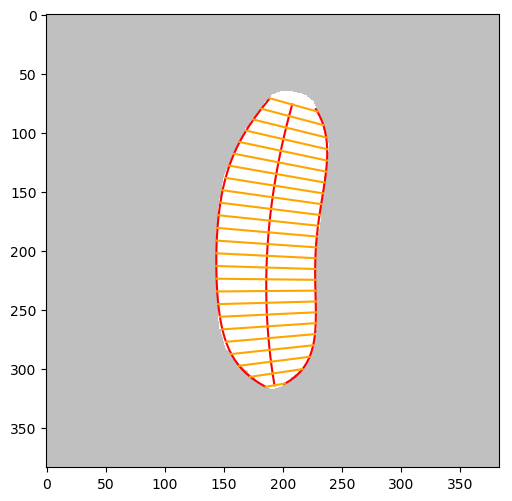

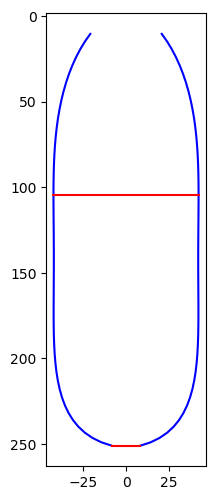

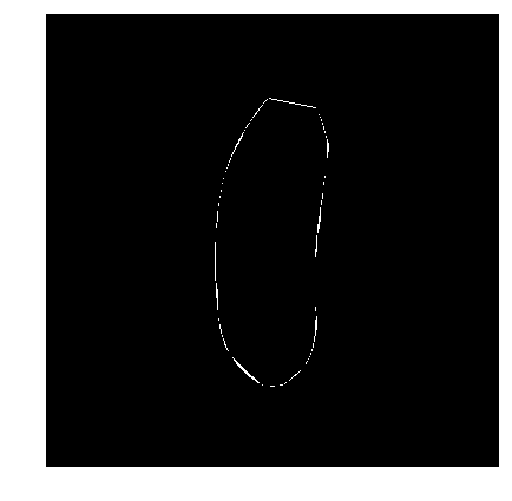

In [264]:
img =imgs[0]  
approxAndMeasurement(img,M=4,N=5,C=3,precPara1=0.05,precPara2=0.01,n_samples=25,openmode=False,debugmode=False,showImage=True)

In [ ]:
img =imgs[1]
approxAndMeasurement(img,M=4,N=5,C=2,precPara1=0.1,precPara2=0.01,n_samples=25,openmode=False,debugmode=False,showImage=True)

dddd -3.80290173601783 5.60928779472618 0.0508270500026404
dddd 11.7541267062207 10.5707210308069 0.0960383240596519
左輪郭点の数  246 　右輪郭点の数　 260


In [ ]:
img =imgs[2]
approxAndMeasurement(img,M=3,N=5,C=3,precPara1=0.1,precPara2=0.01,n_samples=25,openmode=False,debugmode=False,showImage=True)

In [ ]:
img =imgs[3]
approxAndMeasurement(img,M=3,N=5,C=3,precPara1=0.1,precPara2=0.01,n_samples=25,openmode=False,debugmode=False,showImage=True)

# 解説

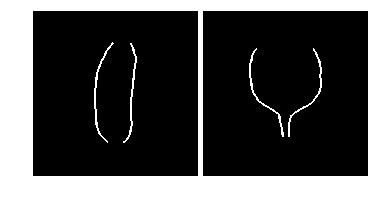

In [3]:
img =imgs[0]
cntl,cntr,cnt = preGetLRdata(img,5,95,bracket=2)
canvas = np.zeros_like(img)
cv2.drawContours(canvas,cntl,-1,255,3)
canvas2 = cv2.drawContours(canvas,cntr,-1,255,3)
img =imgs[1]
cntl,cntr,cnt = preGetLRdata(mg,10,90,bracket=2)
canvas = np.zeros_like(img)
cv2.drawContours(canvas,cntl,-1,255,3)
cv2.drawContours(canvas,cntr,-1,255,3)
imshowpara(canvas2,canvas)

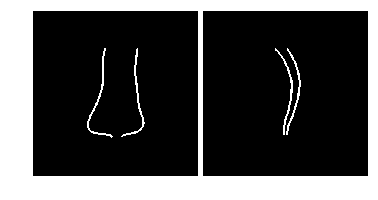

In [4]:
img =imgs[2]
cntl,cntr,cnt = preGetLRdata(img,10,90,bracket=2)
canvas = np.zeros_like(img)
cv2.drawContours(canvas,cntl,-1,255,3)
canvas2 = cv2.drawContours(canvas,cntr,-1,255,3)
img =imgs[3]
cntl,cntr,cnt = preGetLRdata(img,10,90,bracket=2)
canvas = np.zeros_like(img)
cv2.drawContours(canvas,cntl,-1,255,3)
cv2.drawContours(canvas,cntr,-1,255,3)
imshowpara(canvas2,canvas)

# 中心軸の初期近似

# パス１

1. 画像を読み込み、上下方向の５％から９５％の部分を抜き出すことで輪郭点を左右に分ける。
2. 左右それぞれ３次のベジエ曲線で近似し、平均として中心軸をパラメータ表現する。

In [6]:
img =imgs[3]
cntl,cntr,cnt = preGetLRdata(img,5,95,bracket=1)
cpl,cpr,cpc, bezL,bezR,bezC,cntL,cntR = cntPair2bez(cntl,cntr,N=3, precPara=0.1,openmode=False,debugmode=True,showImage=True)

diffpara 0.05962821468710908
diffpara 0.06363712251186379


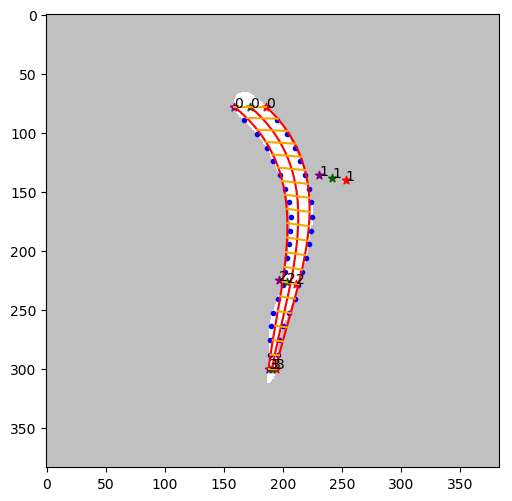

In [7]:
# 結果の表示
drawBez2(img,bezL,bezR,bezC=bezC,cpl=cpl,cpr=cpr,cpc=cpc,cntL=cntL,cntR=cntR,cntC=None, ladder='lr',n_samples=20)

この時点ではズレが大きいが、上下の傾きはほぼ正しく認識できていると考えられる。

## 左右輪郭の再抽出

再度全輪郭を描き、中心軸の延長上に中心をもつ円を黒で描くことで輪郭を左右に分割する。
上下の位置に傾きがあっても比較的良好な分割となる。

左輪郭点の数  226 　右輪郭点の数　 241


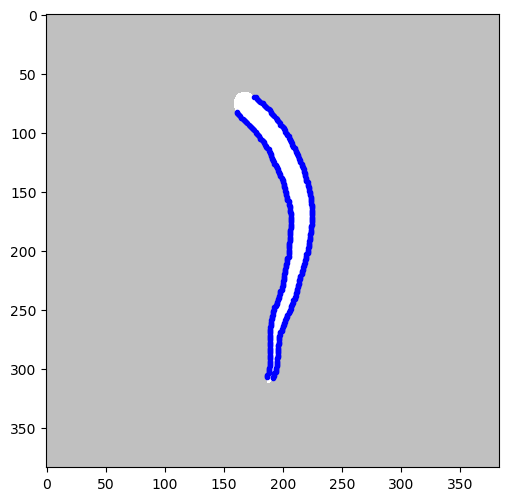

In [8]:
cntl,cntr = reGetCntPair(img,cnt,cpl,cpr,bezC)
drawBez2(img,cntL=cntl,cntR=cntr)

# パス２
再抽出された左右輪郭を５次ベジエ曲線で近似する。

In [9]:
cpl,cpr,cpc, bezL,bezR,bezC,cntL,cntR = cntPair2bez(cntl,cntr,N=5,n_samples=25, precPara=0.01, openmode=False,debugmode=True,showImage=True)

diffpara 0.027459807693958366
diffpara 0.004999995231628418
diffpara 0.028562776744365775
diffpara 0.004999995231628418


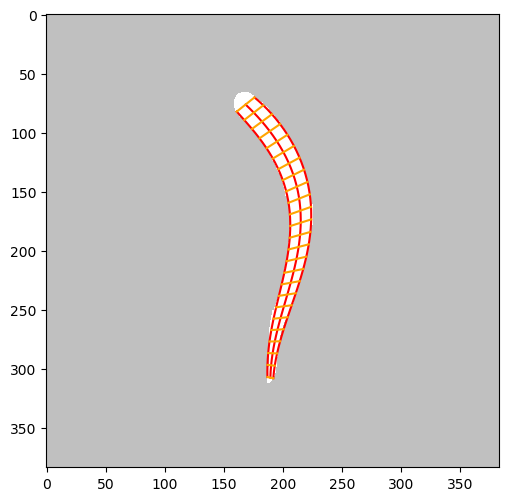

In [10]:
# 結果の表示
drawBez2(img,bezL,bezR,bezC=bezC,ladder='lr',n_samples=25) ;

## 幅の計測
 
 基本的には左右のパラメータ表現の平均はほぼ中心軸に対応すると考えて良いが、上端下端付近の傾きが水平方向から大きくかけ離れた方向になることが多いので、関数に基づいてサンプル点を生成してそれをベジエ曲線で再近似する。

In [11]:
cpxc,cpyc,bezXc,bezYc  = getcenterBez(bezL,bezR,C=4,precPara2=0.01,n_samples = 25, openmode=False,debugmode=True)

diffpara 0.03133213520050057
diffpara 0.0


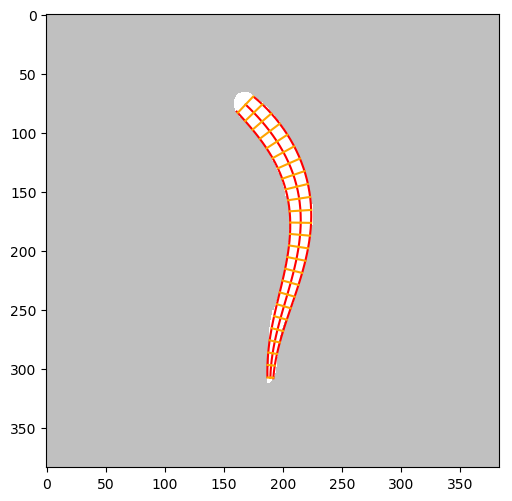

In [12]:
# 結果の表示
PlistL,PlistR = calcWidthFunc(bezL,bezR,bezC,n_samples=25)
drawBez2(img,bezL,bezR,bezC=bezC,ladder='normal',PlistL=PlistL,PlistR=PlistR,n_samples=25) ;

CAP(近似除外上端部)　10.3
ダイコンの長さ=45.0　　（CAPを含む）
最大直径=21.2 最大直径の位置は、上端から100.0 % の位置


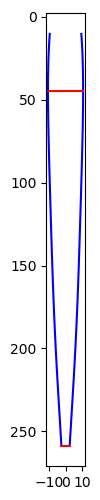

In [13]:
shapeReconstruction(cnt,PosL,PosR,bezL,bezR,bezC,showImage=True);

近似対象の面積は、4123,  輪郭画素数は467,   ずれは、350.0  ピクセル


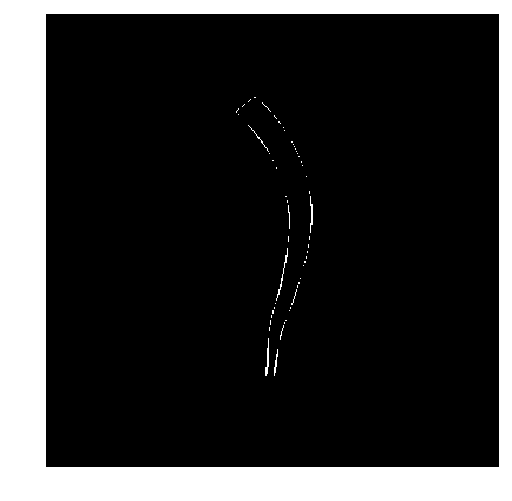

In [86]:
canvas1,canvas2,areas = diffCnt2Bez(img,cnt,cntl,cntr,bezL,bezR, showImage=True)

左輪郭点の数  266 　右輪郭点の数　 254
CAP(近似除外上端部)　10.5
ダイコンの長さ=207.2　　（CAPを含む）
最大直径=133.5 最大直径の位置は、上端から100.0 % の位置
近似対象の面積は、19777,  輪郭画素数は520,   ずれは、839.0  ピクセル


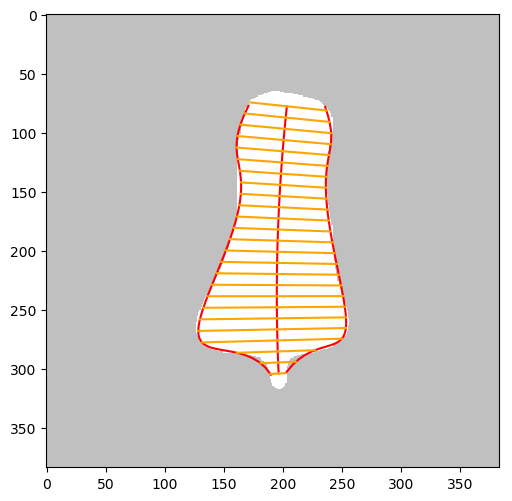

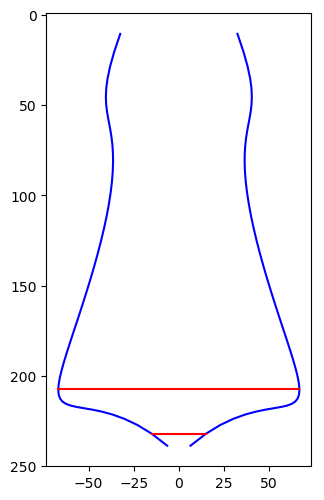

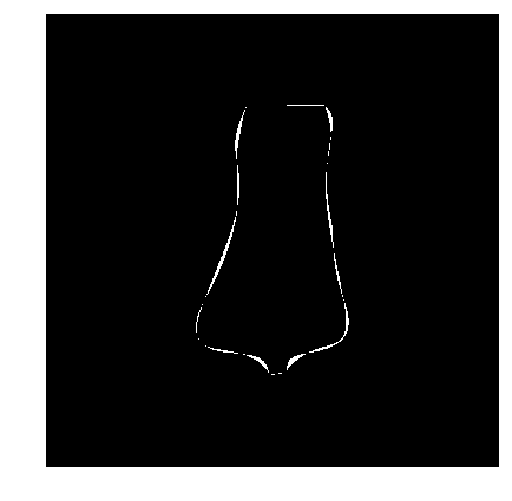

In [180]:
img =imgs[2]
approxAndMeasurement(img,M=3,N=5,C=2,precPara1=0.1,precPara2=0.01,n_samples=25,openmode=False,debugmode=False,showImage=True)

左輪郭点の数  267 　右輪郭点の数　 253
CAP(近似除外上端部)　10.0
ダイコンの長さ=207.4　　（CAPを含む）
最大直径=133.0 最大直径の位置は、上端から100.0 % の位置
近似対象の面積は、19804,  輪郭画素数は520,   ずれは、864.0  ピクセル


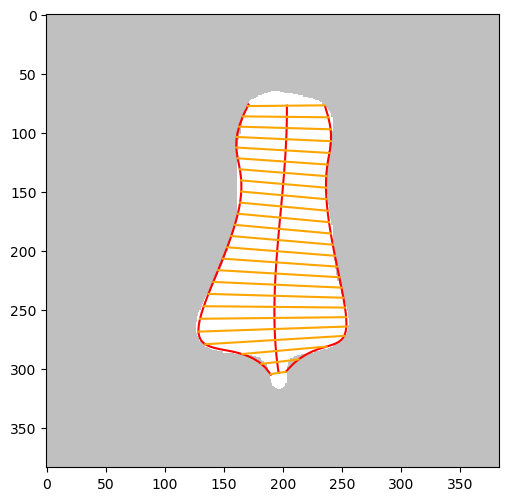

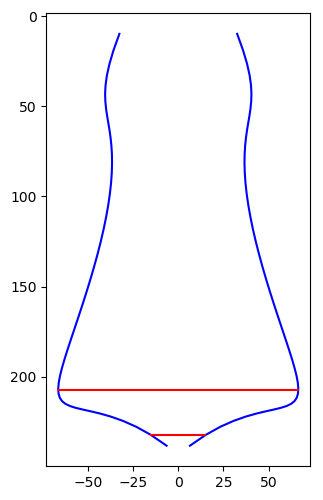

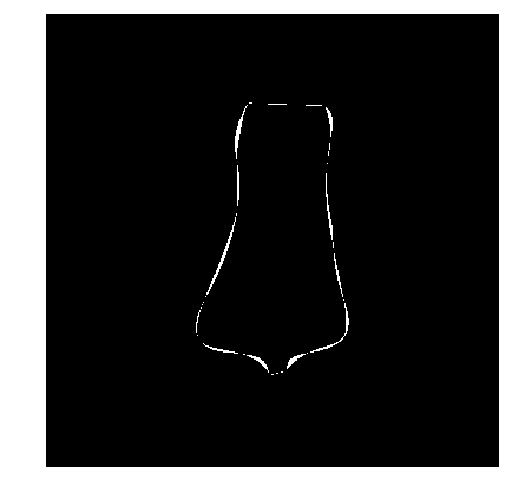

In [181]:
img =imgs[2]
approxAndMeasurement(img,M=4,N=5,C=3,precPara1=0.1,precPara2=0.01,n_samples=25,openmode=False,debugmode=False,showImage=True)

In [188]:
def approxAndMeasurement2(img,M=3,N=5,C=4,precPara1=0.1,precPara2=0.01,n_samples=25,openmode=False,debugmode=False,showImage=True):
    # フェーズ１　仮中心軸の生成
    ## 輪郭線を左右に仮分割
    cntl,cntr,cnt = preGetLRdata(img,5,95,bracket=1)
    ## ベジエ曲線あてはめ（パス１）
    cpl,cpr,cpc, bezL,bezR,bezC,cntL,cntR = cntPair2bez(cntl,cntr,N=M, precPara=precPara1,openmode=openmode,debugmode=debugmode,showImage=showImage)
    ## 中心軸をもとにしてより妥当な左右の輪郭をえる
    cntl,cntr = reGetCntPair(img,cnt,cpl,cpr,bezC)
    ## ベジエ曲線あてはめ （パス２）
    cpl,cpr,cpc, bezL,bezR,bezC,cntL,cntR= cntPair2bez(cntl,cntr,N=N,n_samples=n_samples, precPara=precPara2, openmode=openmode,debugmode=debugmode,showImage=showImage)
    ## 中心軸へのベジエあてはめ
    cpxc,cpyc,bezC2  = getcenterBez(bezL,bezR,C=C,precPara2=precPara2,n_samples = n_samples, openmode=openmode,debugmode=debugmode)
    return cnt,bezL,bezR,bezC2

In [190]:
img =imgs[2]
cnt,bezL,bezR,bezC2=approxAndMeasurement2(img,M=4,N=5,C=3,precPara1=0.1,precPara2=0.01,n_samples=25,openmode=False,debugmode=False,showImage=True)

左輪郭点の数  267 　右輪郭点の数　 253


In [187]:
 bezC2

NameError: name 'bezC2' is not defined